# Gist  

### 1. Problem
Below I am attempting a differentiable programming solution to what is arguably the oldest and most challenging inverse problem.   
The governing equation of the inverse problem we are interested in is none other than the (inhomogeneous) Hemlholtz Equation:  

$$\begin{equation}
\label{eq:helm}
\nabla^2\Psi(\mathbf{r}) + k^2 \psi(\mathbf{r}) = -i \sigma V(\mathbf{r})\psi(\mathbf{r})
\end{equation}
$$
where $\Psi$ is the wavefield, $V$ is the scattering potential, $k^2$ is the wavevector, and $\sigma$ is an interaction strength (or coupling constant).    
The equation above is generally applicable to all forms of radiation (lasers, x-rays...) as well as matter waves (high-energy electron beams, neutrons, etc...).  
In its most general formulation, $\Psi$ is a vector-valued complex field (i.e. to encode polarization states) or in the case of matter waves $\Psi$ is a 4-d spinor. Here, we will ignore polarization states, etc... s.t. we are dealing with scalar fields:  
$$\Psi: \mathbb{R}^3 \rightarrow \mathbb{C}, \quad V: \mathbb{R}^3 \rightarrow \mathbb{R}$$ 

The inverse problem we want to solve is given some data $D = ||\Psi_\textrm{out}||^2$, we would like to recover $V$ (and $\Psi_\textrm{in}$, most researchers only care about $V$ 🤪).  
Multiple variants of this problem arise in many fields and contexts. For instance, in imaging and sensing this inverse problem is known as object reconstruction (i.e. $V$) and in (diffraction) physics/optics it is known as the phase problem ($\arg(\Psi_\textrm{out})$ is not a measurable quantity). 

### 2. Digression #####
-----
```There is tons of approaches to solve this inverse problem (e.g. holography, tomography,) and some like Gabor and Zernike were awarded Nobel Prizes for their work on this problem ... afterall it is the **original inverse problem!**  
So, why bother finding yet another solution to this problem? well... (spoiler alert!!!🚒) none of the above solutions *actually work* in a general sense!  
And by "work in a general sense" I mean: 
1. Algo: here's the associated algorithm 
2. Data: feed it your data 
3. Solution: out comes out get a pretty good solution. 🎊

In fact, researchers, engineers, and companies have spent decades building instruments (CT scanners, microscopes, lightsources, etc...) to make the reconstruction of $V$ easier.   

```
-----

### 3. Paraxial Approximation and the Multi-Slice Algorithm
In what follows we use the paraxial approximation to the inhomogeneous Helmholtz equation:

$$\begin{equation}
\frac{\partial \Psi(\mathbf{r}_\perp)}{\partial z} = \frac{i \lambda}{4 \pi} \nabla_{\perp}^2 \psi(\mathbf{r}_\perp) + i \sigma V(\mathbf{r})\psi(\mathbf{r}_\perp)
\end{equation}
$$


In [37]:
using CuArrays, CUDAdrv, CUDAnative
using LinearAlgebra, Flux, PyPlot
using Flux: Optimise
using Zygote
using FFTW

# FFTW.set_num_threads(40)

# MSA imports
include("MSA.jl")
using .MSA

# CUDAnative.device!(3)
# CuArrays.allowscalar(true)

### Utils


In [23]:
mutable struct ForwardModel
    psi::AbstractArray
    potential::AbstractArray
    name::String
end

function forward(model::ForwardModel)
    psi_buff = Zygote.Buffer(model.potential)
    psi_buff[:,:,:] = model.psi[:,:,:]
    psi_buff = MSA.multislice(model.psi, psi_buff, model.potential, 1, 1, 1)
    model.psi = copy(psi_buff)
    psi_out = model.psi[:,:,end]
    return abs2.(psi_out)
end

function loss(model::ForwardModel, psi2_trg)
    res = norm(forward(model) .- psi2_trg, 2)
    return res
end

function sgd_update!(model::ForwardModel, grads, η = 0.01; verbose=false)
    if verbose 
        @info("Gradients:
            ∂V=$(round.(grads.potential; digits=2))
            ∂ѱ=$(round.(grads.psi; digits=2))")
        @info("before sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
    model.psi .-= η .* grads.psi
    model.potential .-= η .* grads.potential
    if verbose
        @info("after sgd update:
        V'=$(round.(model.potential; digits=2))
        ѱ'=$(round.(model.psi; digits=2))")
    end
end

sgd_update! (generic function with 2 methods)

#### Generate Solution

In [24]:
k_size = (64,64)
num_slices= 32 
@info("Initiate Wavefunction and Scattering Potential...") 
psi_trg = randn(ComplexF32, k_size) 
cpy_trg = copy(psi_trg)
V_trg = im * randn(Float32, (k_size..., num_slices)) 
MSA.multislice!(psi_trg, V_trg, 1, 1, 1)
psi2_trg = abs2.(psi_trg)
# @info("Target Values:")
# println("V=$(round.(V_trg; digits=2))
# ѱ=$(round.(cpy_trg; digits=2))
# psi_out = $(round.(psi2_trg; digits=2))") 

┌ Info: Initiate Wavefunction and Scattering Potential...
└ @ Main In[24]:3


64×64 Array{Float32,2}:
 1.00677    0.661051   0.541983   …  0.0685071  0.57911     1.15243  
 1.39334    0.468789   0.385698      1.06092    0.963139    0.980421 
 1.74066    0.457605   3.14164       1.69613    1.05827     2.38277  
 4.28323    0.900346   1.96416       2.59465    0.812612    1.44236  
 2.86199    0.544454   0.396732      1.51512    3.27699     1.42907  
 0.151654   1.23521    0.208078   …  2.85181    0.198668    0.016672 
 0.228649   0.0740747  0.279417      0.901619   2.44606     0.598385 
 0.479547   4.89582    0.477471      1.24631    1.58076     0.998135 
 0.303354   0.299723   2.85569       0.865552   1.97738     0.488812 
 0.0457868  0.584157   0.571892      4.41675    0.380134    1.25818  
 0.503007   1.43966    0.0305198  …  1.71216    0.334637    1.645    
 0.241774   1.04567    0.0350523     1.92026    0.819476    0.484256 
 0.604829   1.06001    0.823402      0.0570709  0.194038    0.15109  
 ⋮                                ⋱                               

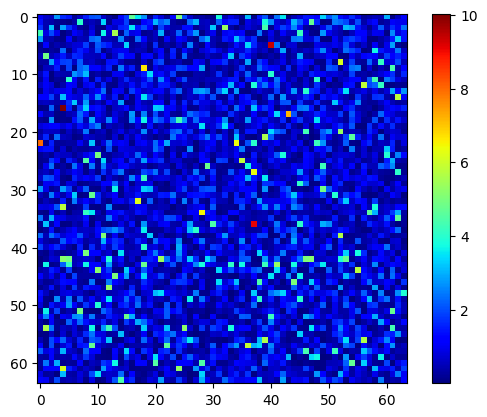

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9930943160>

In [25]:
PyPlot.jet()
imshow(psi2_trg,interpolation="none")
colorbar()

### Initiate Differentiable Forward Model, $\partial F$

In [26]:
@info("Initiate Forward Model...")
scale = Float32(5e-1)
psi_in = randn(ComplexF32, size(V_trg))
V_in = im * randn(Float32, size(V_trg))
model = ForwardModel(psi_in, V_in, "∂F")
@info("Initial Model Values:")
# print("V'=$(round.(model.potential; digits=2))
# ѱ'=$(round.(model.psi; digits=2))
# psi_out = $(round.(forward(model); digits=2))")

┌ Info: Initiate Forward Model...
└ @ Main In[26]:1
┌ Info: Initial Model Values:
└ @ Main In[26]:6


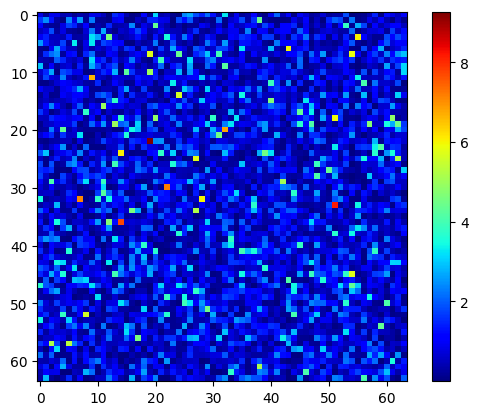

PyObject <matplotlib.colorbar.Colorbar object at 0x7f99308e3c88>

In [27]:
PyPlot.jet()
imshow(forward(model),interpolation="none")
colorbar()

In [28]:
# model gradients
@info("Differentiating Forward Model...")
grads = gradient(model) do m
    return loss(m, psi2_trg)
end
# @info("Gradients:")
# println("
#     ∂V=$(round.(grads.potential; digits=2))
#     ∂ѱ=$(round.(grads.psi; digits=2))")

┌ Info: Differentiating Forward Model...
└ @ Main In[28]:2


(Base.RefValue{Any}((psi = Complex{Float32}[0.0016588822f0 + 0.0034130593f0im 0.004387511f0 + 0.0006882658f0im … -0.0002010221f0 + 0.000923972f0im 1.8139486f-5 - 0.0034211893f0im; -0.005580322f0 - 0.006438204f0im 0.06668614f0 + 0.0040770024f0im … -0.0025077944f0 + 0.005708992f0im -0.006079087f0 + 0.0023554997f0im; … ; -0.0035650274f0 - 0.005255131f0im 0.012096395f0 + 0.017436119f0im … 0.02691673f0 - 0.0036576418f0im 0.0012556254f0 + 0.0029242244f0im; 0.009350926f0 - 0.0022206854f0im -0.027064392f0 + 0.059076726f0im … 0.0008913644f0 + 0.00063333835f0im 0.011313118f0 - 0.022109583f0im]

Complex{Float32}[0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]

Complex{Float32}[0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 

### Difference between initial $\partial F$ and solution

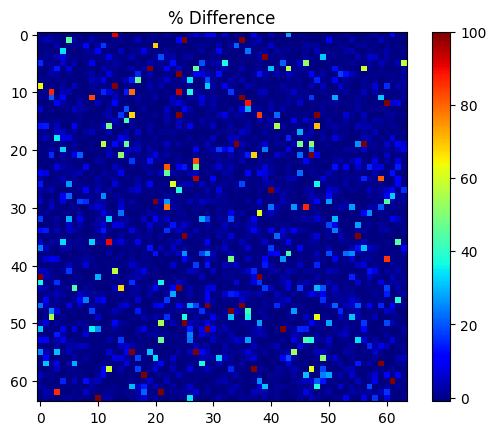

PyObject <matplotlib.colorbar.Colorbar object at 0x7f99306e7588>

In [31]:
PyPlot.jet()
# imshow(imag.(model.potential[:,:,1]),interpolation="none")
# imshow(psi2_trg,interpolation="none")
imshow((forward(model).- psi2_trg)./ psi2_trg, vmax=100)
title("% Difference")
colorbar()

### Optimize

In [32]:
opt = ADAM(1e-3)
@info("Running train loop")
idx = 0
loss_val = loss(model, psi2_trg)
max_iter = 5e2
num_logs = 100
verbose = false
@time while idx < max_iter && loss_val > 1e-4
    if mod(idx, max_iter ÷ num_logs) == 0
        Zygote.@nograd loss_val = loss(model, psi2_trg)
        @info("Iteration=$(idx), Loss=$loss_val")
    end
    grads= Zygote.gradient(model) do m
        return loss(m, psi2_trg)
    end
    grads = grads[1][]
#     sgd_update!(model, grads, 1e-3; verbose=false)
    Optimise.update!(opt, model.psi, grads.psi)
    Optimise.update!(opt, model.potential, grads.potential)
    global idx += 1
end
# @info("Learned parameters:
# V'=$(round.(model.potential; digits=2))
# V=$(round.(V_trg; digits=2))
# ѱ'=$(round.(model.psi; digits=2))
# ѱ=$(round.(cpy_trg; digits=2))")  

┌ Info: Running train loop
└ @ Main In[32]:2
┌ Info: Iteration=0, Loss=92.59459
└ @ Main In[32]:11
┌ Info: Iteration=5, Loss=75.917274
└ @ Main In[32]:11
┌ Info: Iteration=10, Loss=64.449684
└ @ Main In[32]:11
┌ Info: Iteration=15, Loss=55.758877
└ @ Main In[32]:11
┌ Info: Iteration=20, Loss=48.454952
└ @ Main In[32]:11
┌ Info: Iteration=25, Loss=41.673573
└ @ Main In[32]:11
┌ Info: Iteration=30, Loss=35.557163
└ @ Main In[32]:11
┌ Info: Iteration=35, Loss=30.13067
└ @ Main In[32]:11
┌ Info: Iteration=40, Loss=25.168997
└ @ Main In[32]:11
┌ Info: Iteration=45, Loss=20.985397
└ @ Main In[32]:11
┌ Info: Iteration=50, Loss=17.395468
└ @ Main In[32]:11
┌ Info: Iteration=55, Loss=14.242974
└ @ Main In[32]:11
┌ Info: Iteration=60, Loss=11.930804
└ @ Main In[32]:11
┌ Info: Iteration=65, Loss=9.639702
└ @ Main In[32]:11
┌ Info: Iteration=70, Loss=7.240479
└ @ Main In[32]:11
┌ Info: Iteration=75, Loss=4.06979
└ @ Main In[32]:11
┌ Info: Iteration=80, Loss=2.6788995
└ @ Main In[32]:11
┌ Info: Ite

 34.082466 seconds (238.28 M allocations: 63.452 GiB, 2.28% gc time)


### Difference between optimized $\partial F$ and solution

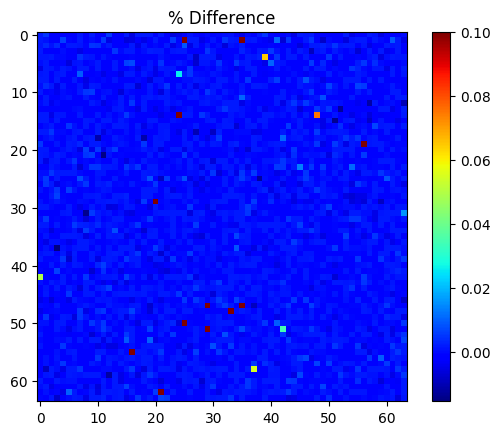

PyObject <matplotlib.colorbar.Colorbar object at 0x7f993041abe0>

In [36]:
PyPlot.jet()
imshow((forward(model).- psi2_trg)./ psi2_trg, vmax=0.1)
title("% Difference")
colorbar()